In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *

In [2]:
level = 60
df60 = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = utils.DataSplitter.performTrainValSplit(df=df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'datetime']

if level != 60:
    dropCols.append('minute')

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

# drop lags
X_train = X_train.loc[:,~X_train.columns.str.contains('^lag', case=False)]
X_val = X_val.loc[:,~X_val.columns.str.contains('^lag', case=False)]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

In [3]:
X_train.columns

Index(['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun',
       'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation',
       'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation',
       'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure',
       'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth',
       'event'],
      dtype='object')

# Benchmark

## Seasonal naive with season 140 hours

Execution time: 0.003 sec
train MAE%: 0.17
train MAPE: 0.229
train RMSE%: 0.278
val MAE%: 0.134
val MAPE: 0.15
val RMSE%: 0.193


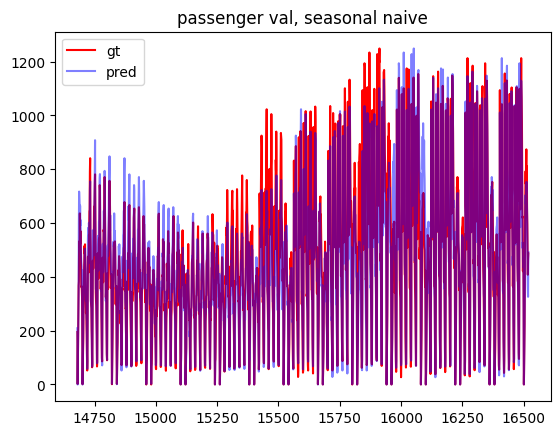

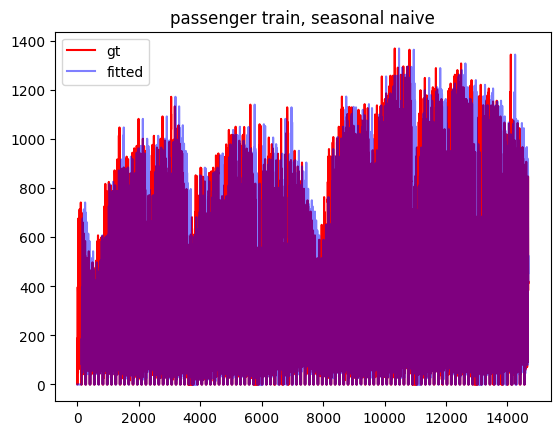

In [4]:
lookback = 140*agg # 140 * amount of observations per hour

timer = Time()
timer.start()
# same as past 140th observation
y_train_pred = y_train.shift(periods=lookback).fillna(0)
# concat train and val so lags are possible. Find same as past 140th observation.
y_val_pred = pd.concat([y_train, y_val]).shift(periods=lookback).fillna(0)[y_val.index]
print(timer.end())

# round and cut off train and val predictions
y_train_pred = y_train_pred.round()
y_train_pred[y_train_pred < 0] = 0
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, seasonal naive')
plt.legend()
plt.show()

plt.plot(X_train.index, y_train, color='red', label='gt')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
plt.title('passenger train, seasonal naive')
plt.legend()
plt.show()

# Lasso

c:\Users\Andre\OneDrive\Dokumenter\GitHub\Machine-Learning-Passenger-Forecasting\utils\Sklearn.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val_pred = pd.Series()


Execution time: 0.271 sec
train MAE%: 0.148
train MAPE: 0.261
train RMSE%: 0.207
val MAE%: 0.128
val MAPE: 0.249
val RMSE%: 0.175


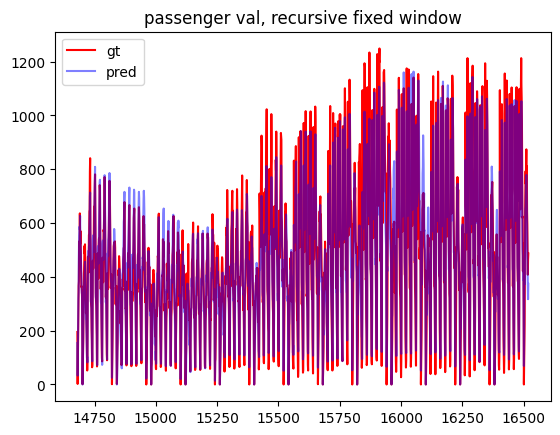

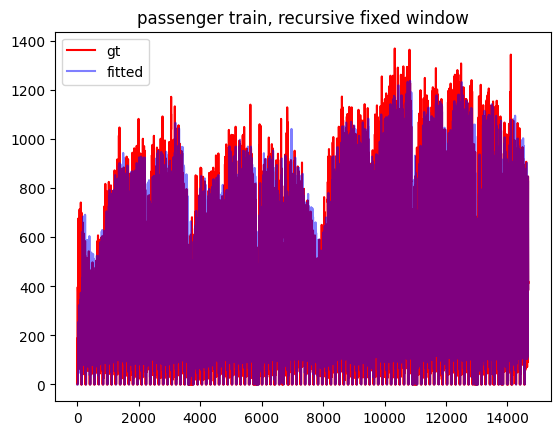

                            OLS Regression Results                            
Dep. Variable:     passengersBoarding   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     3482.
Date:                Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:46:04   Log-Likelihood:                -87141.
No. Observations:               14680   AIC:                         1.743e+05
Df Residuals:                   14646   BIC:                         1.746e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  362.9926 

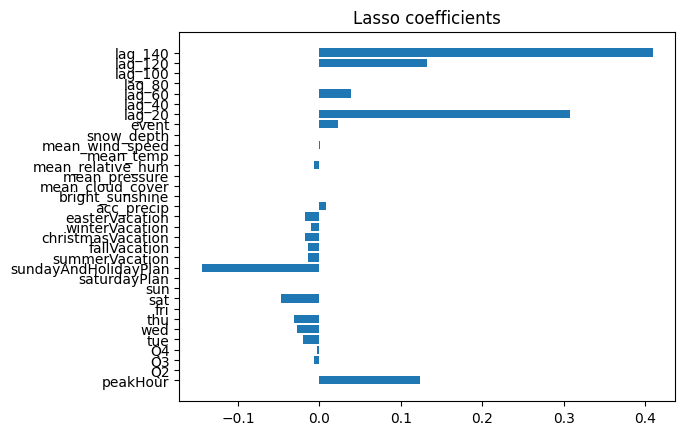

In [5]:
# fixed window 40 hours ahead
horizon = 40*agg

# best 60 min without diff
lags = [20, 40, 60, 80, 100, 120, 140]
diff = None
alpha = 0.01

# best 60 min with diff
#lags = [140]
#diff = 1
#alpha = 0.01

# best 30 min without diff
#lags = [40, 80, 120, 160, 200, 240, 280]
#diff = None
#alpha = 0.01

# best 30 min with diff
#lags = [2, 40, 80, 120, 160, 200, 240, 280]
#diff = 1
#alpha = 0.01

# best 15 min without diff
#lags = [80, 160, 240, 320, 400, 480, 560]
#diff = None
#alpha = 0.01

# best 15 min with diff
#lags = [4, 80, 160, 240, 320, 400, 480, 560]
#diff = 1
#alpha = 0.01

model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.Sklearn.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, y_val, color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

plt.plot(X_train.index, y_train, color='red', label='gt')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
#plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger train, recursive fixed window')
plt.legend()
plt.show()

# Use statsmodels to perform OLS regression and output summary
X_train_lagged = X_train.copy(deep=True)
if lags:
    for lag in lags:
        X_train_lagged[f'lag_{lag}'] = y_train.shift(periods=lag).fillna(0)
ols_model = sm.OLS(y_train, sm.add_constant(X_train_lagged)).fit()
print(ols_model.summary())

plt.barh(X_train_lagged.columns, model.coef_)
plt.title('Lasso coefficients')
plt.show()

# Lasso grid search

In [6]:
# fixed window forecast
import warnings
warnings.filterwarnings("ignore")

horizon = 40*agg
bestMAE = 100000
laglist = [[1], [2], [3], [4], [5], [6], [7], [8], [20], [40], [60], [80], [100], [120], [140],
           [1, 20, 140], [1, 4, 7, 8, 20],
           [1, 20, 40, 60, 80, 100, 120, 140],
           [1, 2, 3, 4, 5, 6, 7, 8], [20, 40, 60, 80, 100, 120, 140]]

laglist = [[i*agg for i in templist] for templist in laglist]

for diff in [1, None]:
    for lags in laglist:
        for alpha in [0.3, 0.2, 0.1, 0.05, 0.01]:
            model = Lasso(alpha=alpha, fit_intercept=True, max_iter=1000)
            scalar = StandardScaler()
            exog_scalar = StandardScaler()

            model, y_train_pred, y_val_pred = utils.Sklearn.fixedWindowForecastSklearn(
                X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
                horizon=horizon, differentiation=diff, lags=lags, 
                scalar=scalar, exog_scalar=exog_scalar)

            trainMAE = MAE(y=y_train, yhat=y_train_pred)
            valMAE = MAE(y=y_val, yhat=y_val_pred)
            if valMAE < bestMAE:
                bestMAE = valMAE
                print(alpha, diff, lags)
                print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
                print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
                print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

                print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
                print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
                print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

print('done')

Execution time: 0.272 sec
0.3 1 [1]
train MAE%: 0.686
train MAPE: 1.011
train RMSE%: 0.874
val MAE%: 0.673
val MAPE: 1.364
val RMSE%: 0.858
Execution time: 0.262 sec
Execution time: 0.268 sec
Execution time: 0.278 sec
0.05 1 [1]
train MAE%: 0.605
train MAPE: 0.876
train RMSE%: 0.783
val MAE%: 0.642
val MAPE: 1.303
val RMSE%: 0.826
Execution time: 0.280 sec
0.01 1 [1]
train MAE%: 0.562
train MAPE: 0.883
train RMSE%: 0.726
val MAE%: 0.622
val MAPE: 1.275
val RMSE%: 0.807
Execution time: 0.260 sec
Execution time: 0.267 sec
Execution time: 0.271 sec
Execution time: 0.288 sec
Execution time: 0.268 sec
0.01 1 [2]
train MAE%: 0.617
train MAPE: 0.948
train RMSE%: 0.785
val MAE%: 0.569
val MAPE: 1.192
val RMSE%: 0.741
Execution time: 0.264 sec
Execution time: 0.270 sec
Execution time: 0.262 sec
Execution time: 0.276 sec
Execution time: 0.257 sec
0.01 1 [3]
train MAE%: 0.62
train MAPE: 0.941
train RMSE%: 0.787
val MAE%: 0.514
val MAPE: 1.174
val RMSE%: 0.678
Execution time: 0.288 sec
Execution t

Best 60min with 1-diff: alpha=0.01, diff=1, lag=[140]

Training: MAE: 0.168, MAPE: 0.32, RMSE: 0.238

Validation: MAE: 0.19, MAPE: 0.281, RMSE: 0.257


Best 60min without 1-diff: alpha=0.01, diff=None, lags=[20, 40, 60, 80, 100, 120, 140]

Training: MAE: 0.148, MAPE: 0.261, RMSE: 0.207

Validation: MAE: 0.128, MAPE: 0.249, RMSE: 0.175

Best 30min with 1-diff: alpha=0.01, diff=1, lags=[2, 40, 80, 120, 160, 200, 240, 280]

Training: MAE: 0.156, MAPE: 0.414, RMSE: 0.216

Validation: MAE: 0.307, MAPE: 0.631, RMSE: 0.39


Best 30min without 1-diff: alpha=0.01, diff=None, lags=[40, 80, 120, 160, 200, 240, 280]

Training: MAE: 0.164, MAPE: 0.45, RMSE: 0.228

Validation: MAE: 0.143, MAPE: 0.389, RMSE: 0.195

Best 15min with 1-diff: alpha=0.01, diff=1, lag=[4, 80, 160, 240, 320, 400, 480, 560]

Training: MAE: 0.180, MAPE: 0.333, RMSE: 0.247

Validation: MAE: 0.465, MAPE: 0.802, RMSE: 0.581


Best 15min without 1-diff: alpha=0.01 , diff=None, lag=[80, 160, 240, 320, 400, 480, 560]

Training: MAE: 0.188, MAPE: 0.368, RMSE: 0.257

Validation: MAE: 0.167, MAPE: 0.316, RMSE: 0.226

# test windows with and without lags and exog

/Users/andreasskibyandersen/Library/Mobile Documents/com~apple~CloudDocs/Universitet/6_Semester/Bachelor/Machine-Learning-Passenger-Forecasting/utils/Sklearn.py:86: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_val_pred = pd.concat([y_val_pred, preds])


Execution time: 0.254 sec
train MAE%: 0.168
train MAPE: 0.32
train RMSE%: 0.238
val MAE%: 0.134
val MAPE: 0.253
val RMSE%: 0.181


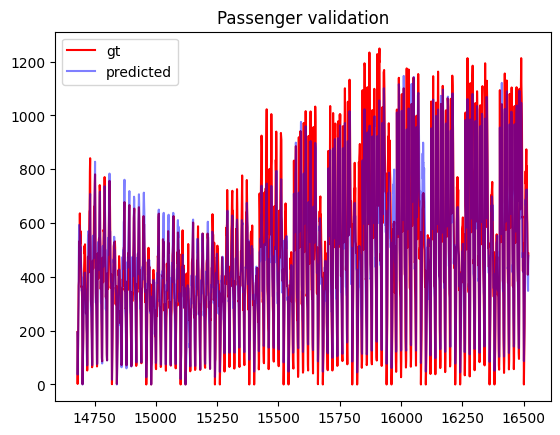

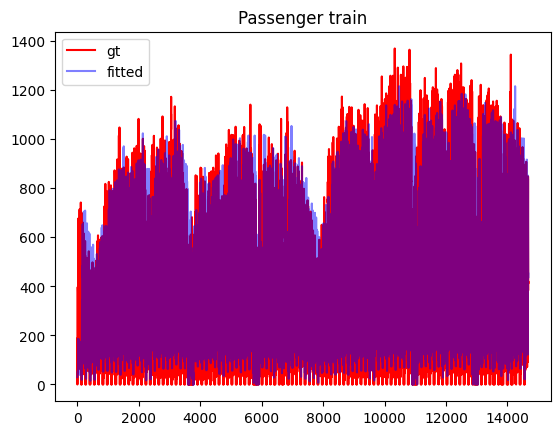

In [3]:
model = Lasso(alpha=0.01, fit_intercept=True, max_iter=1000)
scalar = StandardScaler()
exog_scalar = StandardScaler()
horizon = 40

model, y_train_pred, y_val_pred = utils.Sklearn.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=None, lags=[140], 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', RMSE(y=y_val, yhat=y_val_pred))

plt.plot(y_val.index, y_val, color='red', label='gt')
plt.plot(y_val.index, y_val_pred, color='blue', alpha=0.5, label='predicted')
plt.title('Passenger validation')
plt.legend()
plt.show()

plt.plot(y_train.index, y_train, color='red', label='gt')
plt.plot(y_train.index, y_train_pred, color='blue', alpha=0.5, label='fitted')
plt.title('Passenger train')
plt.legend()
plt.show()